In [5]:
from __future__ import print_function
import os
import sys
import math
import pickle
import pdb
import argparse
import random
from tqdm import tqdm
from shutil import copy
import torch
from torch import nn, optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import scipy.io
from scipy.linalg import qr 
import igraph as ig
from random import shuffle
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from util import *
from modelsRIGHT import *
from bayesian_optimization.evaluate_BN import Eval_BN
from igraph import *
import networkx as nx
from collections import Counter
import statistics
import util
import itertools
from sklearn.decomposition import PCA
import dotmap
from dotmap import DotMap
import pandas as pd



args = DotMap()
args.cuda = True
args.lr = 1e-3
args.all_gpus=False
args.batch_size=1024
args.bidirectional=False
args.continue_from=None
args.data_name='final_structures6'
args.data_type='BN'
args.epochs=200
args.hs=128
args.infer_batch_size=64
args.keep_old=False
args.load_latest_model=False
args.lr=0.0001
args.model='DVAE_NOBATCHNORM'
args.no_cuda=False
args.no_test=False
args.nvt=6
args.nz=4
args.only_test=False
args.predictor=False
args.reprocess=False
args.sample_number=20
args.save_appendix=''
args.save_interval=10
args.seed=1
args.small_train=False
args.beta = 0.1


In [2]:
# df = pd.read_csv("vertex_4_2dim_latent_batchnorm2\\final_structures6\\train_loss.txt", sep= " ")
# df2 = pd.read_csv("vertex_4_4dim_latent\\final_structures6\\train_loss.txt", sep= " ")
# df3 = pd.read_csv("train_lossBIG.txt", sep= " ")
# df4 = pd.read_csv("vertex_4_2dimLatent_new\\final_structures6\\train_loss.txt", sep= " ")



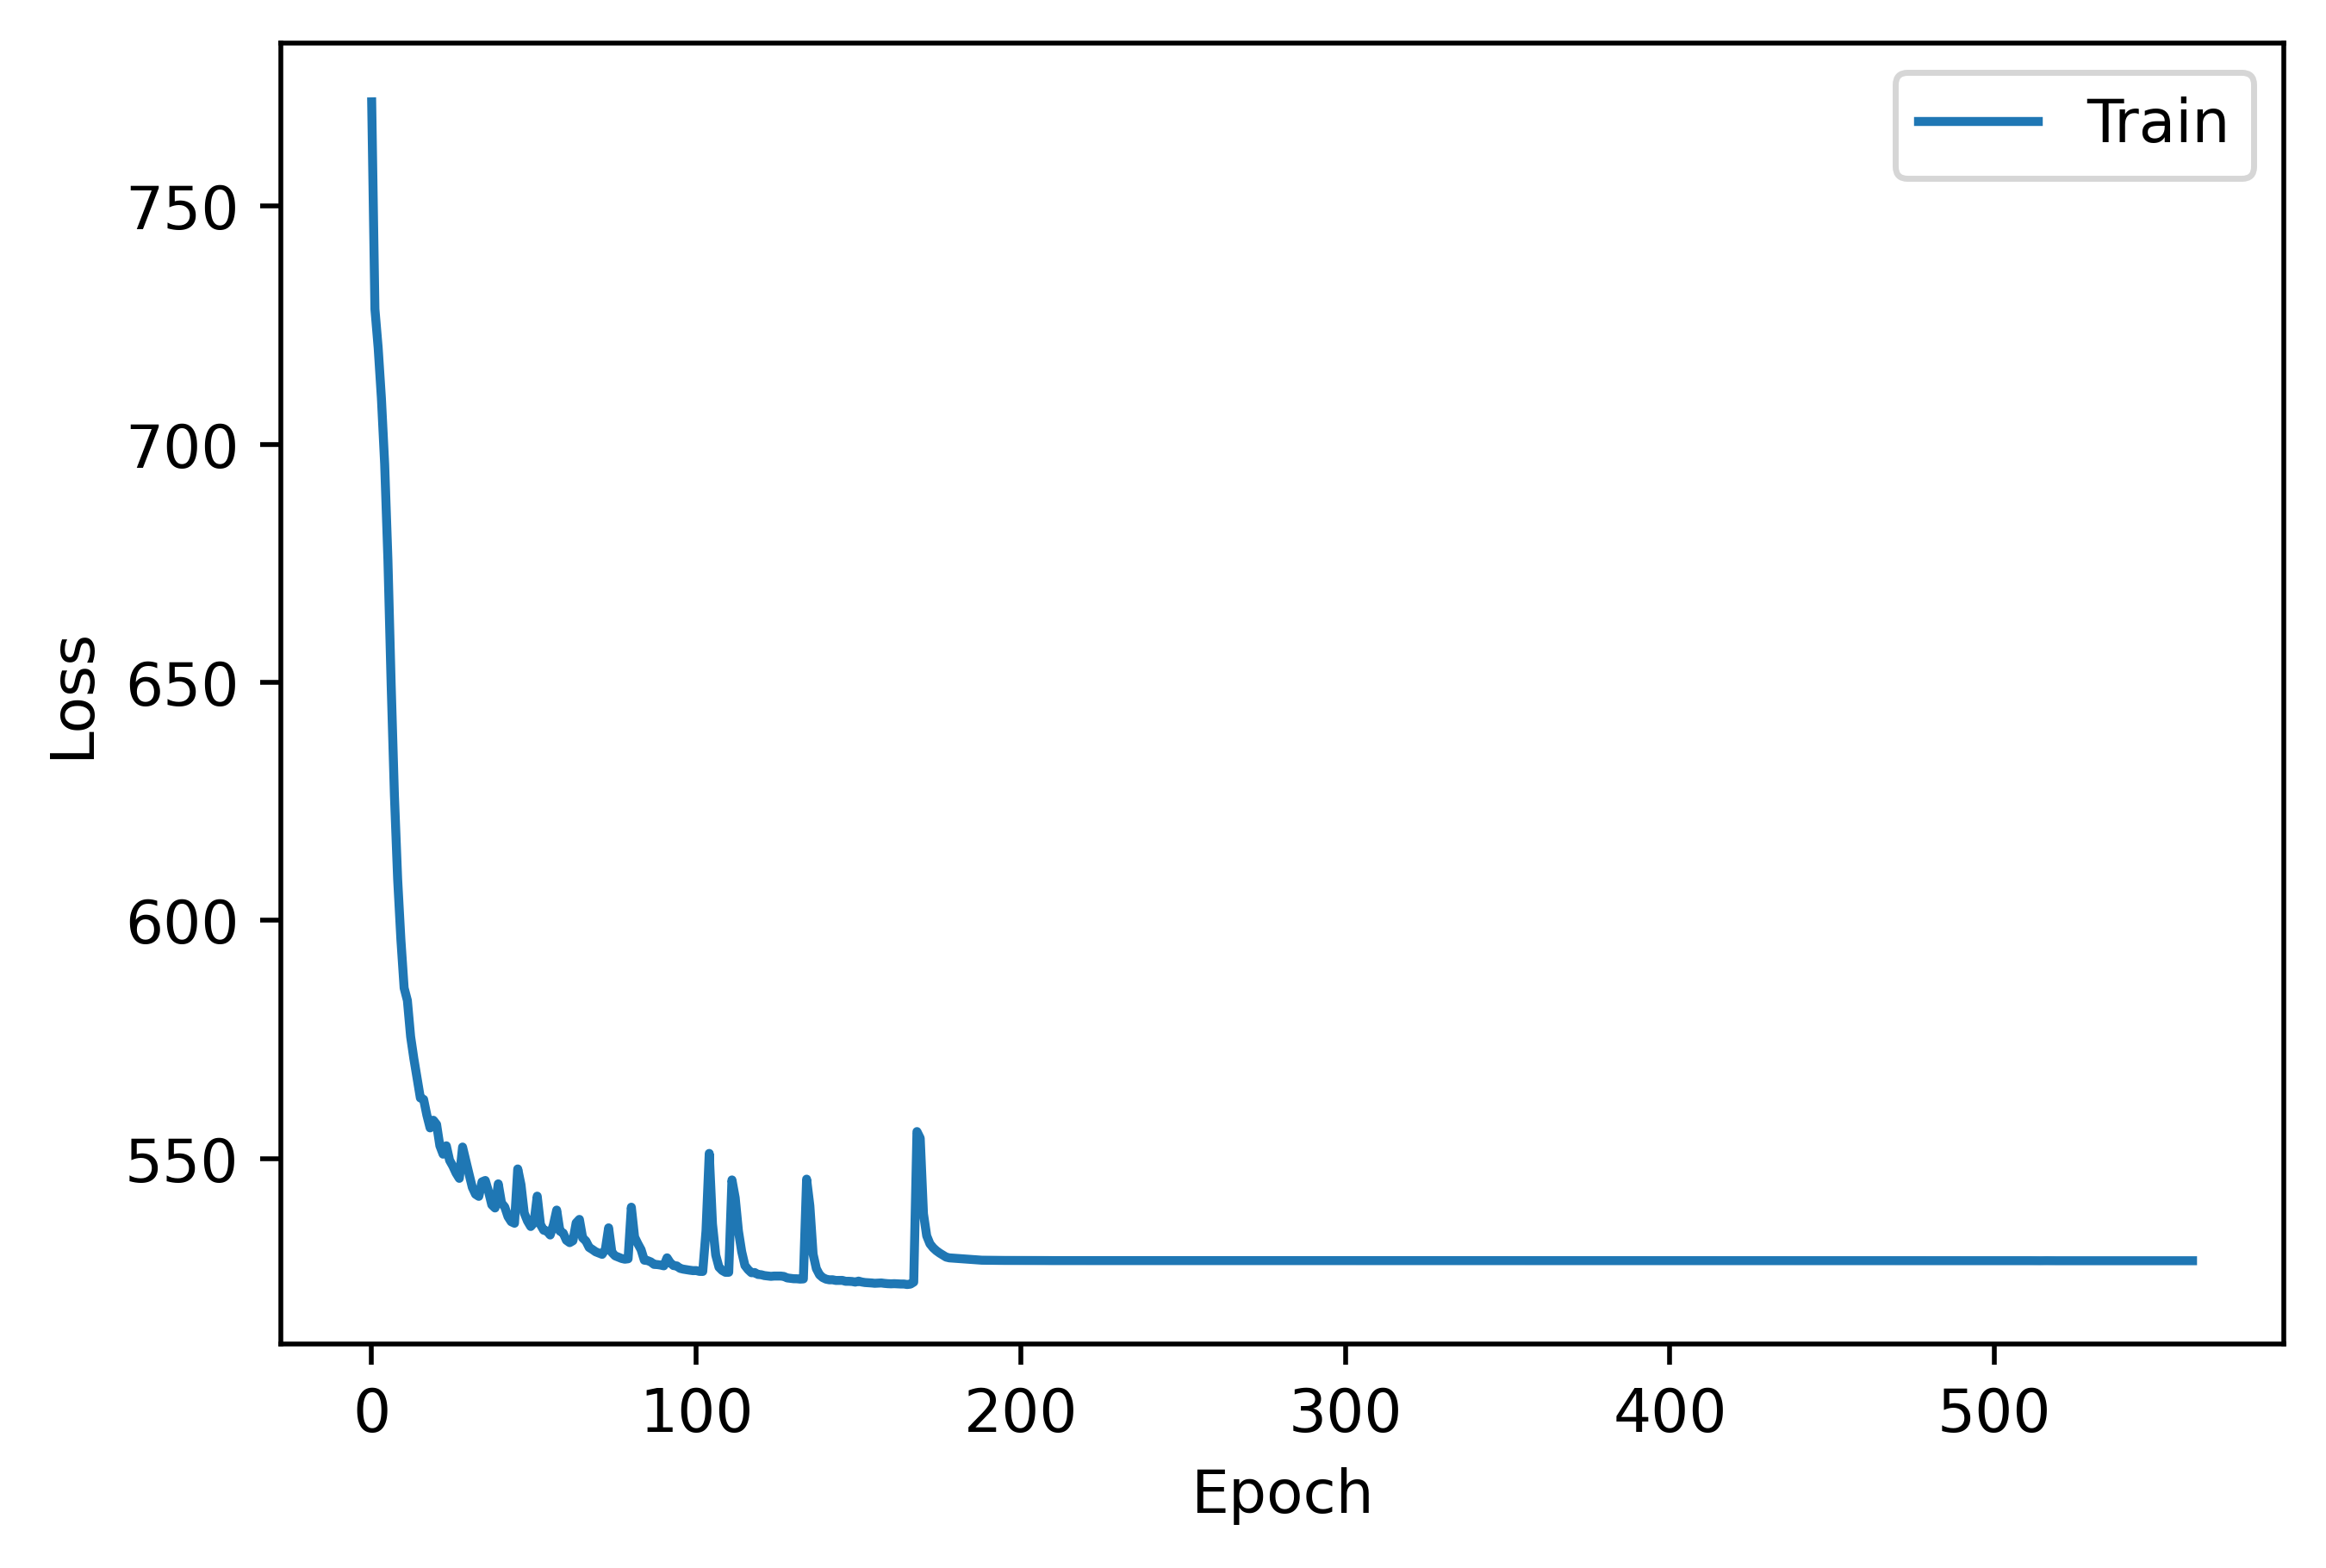

In [6]:
# plt.figure(dpi = 500)

# plt.plot(df3.iloc[:2949,0], label='Train')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.plot(df3.iloc[:2949,4], label='Total')

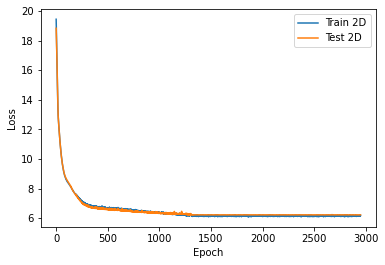

In [86]:
# # print(df.iloc[:,0])
# plt.plot(range(1, 2950),df4.iloc[:2949,0], label='Train 2D')
# plt.plot(range(1, 2950),df4.iloc[:2949,4], label='Test 2D')
# # plt.plot(range(1, 2950),df2.iloc[:2949,0], label='Train 4D')
# # plt.plot(range(1, 2950),df2.iloc[:2949,4], label='Test 4D')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()

In [87]:


args.cuda = not args.no_cuda and torch.cuda.is_available()
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
np.random.seed(args.seed)
random.seed(args.seed)
print(args)
print(device)


DotMap(cuda=True, lr=0.0001, all_gpus=False, batch_size=1024, bidirectional=False, continue_from=None, data_name='final_structures6', data_type='BN', epochs=200, hs=128, infer_batch_size=64, keep_old=False, load_latest_model=False, model='DVAE_BN', no_cuda=False, no_test=False, nvt=6, nz=4, only_test=False, predictor=False, reprocess=False, sample_number=20, save_appendix='', save_interval=10, seed=1, small_train=False)
cuda:0


In [88]:
graph_args = DotMap()
graph_args.max_n = 6
graph_args.num_vertex_type = 6
graph_args.START_TYPE = 0
graph_args.END_TYPE = 1
model = eval(args.model)(
        graph_args.max_n, 
        graph_args.num_vertex_type, 
        graph_args.START_TYPE, 
        graph_args.END_TYPE, 
        hs=args.hs, 
        nz=args.nz, 
        bidirectional=args.bidirectional        )
model.device = device
model = model.to(device)
print(model.get_device())
optimizer = optim.Adam(model.parameters(), lr=args.lr)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=10, verbose=True)

cuda:0


In [89]:
all_data = []
all_data2 = []
train_data = []
test_data = []

for filename in os.listdir("..\\graph_data\\vertex_4_new"):
    path = os.path.join("..\\graph_data\\vertex_4_new", filename)
    with open(path, 'rb') as pickle_file:
        # Load file
        graph = pickle.load(pickle_file)
        edge_list = graph.get_edgelist()
        # Create new graph
        graph2 = ig.Graph(directed=True)
        graph2.add_vertices(6)
        # Copy vertices to new graph
        for vs_i in range(len(graph.vs)):
            graph2.vs[vs_i+1]['type'] =  graph.vs[vs_i]['type']+2
        # Copy edges to new graph
        for edge_pair in edge_list:
            p1 = edge_pair[0]
            p2 = edge_pair[1]
            graph2.add_edge(p1+1,p2+1)
        # Set vertex attributes
        graph2.vs[0]['type'] = graph_args.START_TYPE
        graph2.vs[5]['type'] = graph_args.END_TYPE
        # graph2.add_edge(0,1)
        # graph2.add_edge(4,5)

        for vs_i,vs in enumerate(graph2.vs[1:-1]):
            if(len(vs.in_edges()) == 0):
                graph2.add_edge(0, vs_i+1)
            if(len(vs.out_edges()) == 0):
                graph2.add_edge(vs_i+1, len(graph2.vs)-1)
        all_data.append(graph2)
        all_data2.append(graph2)
print(all_data[0].vs["type"])
print(all_data[1].vs["type"])
print(len(all_data))

[0, 2, 3, 4, 5, 1]
[0, 2, 3, 5, 4, 1]
543


In [90]:
q = 2950
p = os.path.join("vertex_4_4dim_nobatchnorm_middleKL_KAGGLE","results_v4","final_structures6","model", 'model_checkpoint'+str(q)+'.pth')
load_module_state(model,p)



In [91]:
latents = []
extended = []
min_mu = 2
max_mu = -1
min_g = None
max_g = None
for data in all_data:
    mu, _ = model.encode(data)
    mu = mu.cpu().detach().numpy()
    latents.append(mu)
    null_edges = data.neighbors(0, 'out')
    # print(data.vcount())
    end_edges = data.neighbors(5, 'in')
    max_degree = np.max(data.vs.degree())
    in_degree = np.max(data.vs.indegree())
    out_degree = np.max(data.vs.outdegree())
    zero_pred =  len([ix for ix in range(data.vcount()) if  data.neighbors(ix, "in") == [0]])    
    zero_succ = len([ix for ix in range(data.vcount()) if  data.neighbors(ix, "out") == [5]])
    
    minus_edges = len(null_edges) + len(end_edges)
    mu  = np.append(mu, data.ecount()- minus_edges)
    mu  = np.append(mu, max_degree)
    mu  = np.append(mu, in_degree)
    mu  = np.append(mu, out_degree)
    mu  = np.append(mu, zero_pred)
    mu  = np.append(mu, zero_succ)




    
    extended.append(mu)

latents = np.array(latents)
extended = np.array(extended)
print(latents.shape)
# print(latents)

(543, 1, 4)


In [92]:
# print(extended.shape)
# fig, ax = plt.subplots()
# scatter = ax.scatter(extended[:,0], extended[:,1], c=extended[:,2])

# legend1 = ax.legend(*scatter.legend_elements(),
#                     loc="upper left",bbox_to_anchor=(1.04, 1))
# ax.add_artist(legend1)
# plt.show()


In [93]:
# one_edge = [x for x in extended if x[2] ==0 or x[2] ==1 ]
# one_edge = np.array(one_edge)
# # print(one_edge[:,1])
# # print(type(one_edge))
# plt.scatter(one_edge[:,0], one_edge[:,1], c= one_edge[:,6])

<class 'numpy.ndarray'>


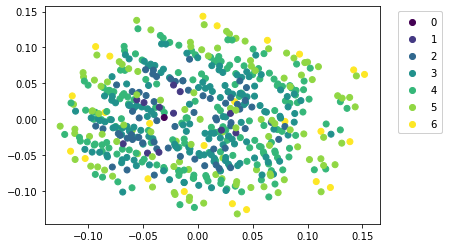

In [94]:
a = latents.reshape((543,4))
pca = PCA(n_components=2)
components = pca.fit_transform(a)
print(type(components))
# plt.scatter(components[:,0], components[:,1], c=extended[:,6])

fig, ax = plt.subplots()
scatter = ax.scatter(components[:,0], components[:,1], c=extended[:,4])

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper left",bbox_to_anchor=(1.04, 1))
ax.add_artist(legend1)
plt.show()

In [95]:
# # 4DIM latent 
# print(latents.shape)
# a = latents.reshape((543,4))
# print(a.shape)
# pca = PCA(n_components=2)
# components = pca.fit_transform(a)
# print(components.shape)
# extended = []
# for data, component in zip(all_data, components):
#     max_degree = np.max(data.vs.degree())
#     null_edges = data.neighbors(0, 'out')
#     end_edges = data.neighbors(5, 'in')
#     minus_edges = len(null_edges) + len(end_edges)
#     component = np.append(component, data.ecount()- minus_edges)
#     component = np.append(component, max_degree)
#     extended.append(component)
    
# extended = np.array(extended)

# print(extended.shape)
# plt.scatter(extended[:,0], extended[:,1], c=extended[:,3])

In [96]:
# print(extended[:,2])
# one_edge = [x for x in extended if x[2] == 6]
# one_edge = np.array(one_edge)
# print(one_edge.shape)
# plt.scatter(one_edge[:,0], one_edge[:,1], c=one_edge[:,3])

In [97]:
# # print(latents[:, 2])
# # plt.scatter( latents[:,0], latents[:,1], c=latents[:,4])
# plt.scatter(latents[:,0], [0] * latents[:,0].shape[0], c=latents[:,3])
# plt.show()

In [98]:
# print(min_mu)
# print(min_g)
# print("----")
# print(max_mu)
# print(max_g)
# one_edge = [x for x in latents if x[1] == 8]
# one_edge = np.array(one_edge)
# # plt.scatter( one_edge[:,0], one_edge[:,1], c=one_edge[:,7])

# plt.scatter(one_edge[:,0], [0] * one_edge[:,0].shape[0], c=one_edge[:,3])

# plt.show()
# print(len(one_edge))


In [99]:
# second_edge = [x for x in latents if x[2] == 8]
# second_edge = np.array(second_edge)
# plt.scatter( second_edge[:,0], second_edge[:,1], c=second_edge[:,4])
# plt.show()
# print(len(second_edge))


In [100]:


def prior_validity():
    Z_train = latents
    Zs_valid = []
    Zs_invalid = []
    Zs_plus_decode = []
    z_mean, z_std = np.array(Z_train.mean(0)) ,np.array(Z_train.std(0)) 
    print(z_mean)
    print(z_std)
    z_mean, z_std = torch.FloatTensor(z_mean).to(device), torch.FloatTensor(z_std).to(device)
    n_latent_points = 1000
    decode_times = 10
    n_valid = 0
    print('Prior validity experiment begins...')
    G = []
    G_valid = []
    G_train = [g for g in train_data]
    pbar = tqdm(range(n_latent_points))
    cnt = 0
    G_valid = []
    G_invalid = []
    n_valid = 0
    for i in pbar:
        cnt += 1
        if cnt == args.infer_batch_size or i == n_latent_points - 1:
            z = torch.randn(cnt, model.nz).to(model.get_device())
        # print(z)
            z = z * z_std + z_mean  # move to train's latent range
        # print(z)
            
            # print(z.cpu().detach().numpy())

            for j in range(decode_times):
                g_batch = model.decode(z)
                for ix,g in enumerate(g_batch):
                    if is_valid_BN(g, graph_args.START_TYPE, graph_args.END_TYPE,args.nvt):
                        n_valid +=1
                        G_valid.append(g)
                        Zs_valid.append(z.cpu().detach().numpy()[ix])
                    else:
                        G_invalid.append(g)
                        Zs_invalid.append(z.cpu().detach().numpy()[ix])


            cnt = 0
    return G_valid, G_invalid, Zs_valid, Zs_invalid


valid, invalid, Zs_valid, Zs_invalid = prior_validity()
print(len(valid))
print(len(invalid))


[[-0.00034486 -0.00195809 -0.00192368 -0.00065719]]
[[0.05970855 0.05984702 0.04838736 0.05488191]]
Prior validity experiment begins...


100%|██████████| 1000/1000 [00:43<00:00, 23.22it/s]

9940
60


In [101]:
# print(len(Zs_plus_decode))


In [102]:
print(invalid[0])
print(invalid[0].vs["type"])

IGRAPH D--T 6 7 --
+ attr: type (v)
+ edges:
0->1 0->2 0->3 3->4 1->5 2->5 4->5
[0, 2, 3, 2, 4, 1]


In [103]:
print(len(all_data))
print(len(valid))
valid2 = valid.copy()
for g in all_data2:
    to_delete_ids = [v.index for v in g.vs if v["type"] == 0 or v["type"] == 1]
    g.delete_vertices(to_delete_ids)

for g in valid2:
    to_delete_ids = [v.index for v in g.vs if v["type"] == 0 or v["type"] == 1]
    g.delete_vertices(to_delete_ids)

543
9940


In [104]:
def is_same_DAG2(g0, g1):
    # note that it does not check isomorphism
    if g0.vcount() != g1.vcount():
        return False
    if set(g0.vs["type"]) != set(g1.vs["type"]):
        return False
    if g0.ecount() != 0 or g1.ecount() == 0:
        for vi in range(g0.vcount()):
            g0_index_of_type = g0.vs.find(type=vi+2)
            g1_index_of_type = g1.vs.find(type=vi+2)
            # g0_vs = g0.vs[g0_index_of_type]
            # g1_vs = g1.vs[g1_index_of_type]

            # if g0.vs[vi]['type'] != g1.vs[vi]['type']:
            #     return False
            g0_neighbours = set([g0.vs[vs_i]["type"] for vs_i in g0.neighbors(g0_index_of_type, 'in')])
            g1_neighbours = set([g1.vs[vs_i]["type"] for vs_i in g1.neighbors(g1_index_of_type, 'in')])
            if g0_neighbours != g1_neighbours:
                return False
    return True

In [105]:
# def unique2(graph_list, all_graphs):
#     d = 0
#     graph_list = graph_list.copy()
#     ixs = [0 for _ in range(len(all_graphs)+1)]
#     for ix_a,a_g in enumerate(all_graphs):
#         b = True
#         j = 0
#         while len(graph_list) != 0:
#             g = graph_list[j]
#             if  is_same_DAG2(a_g,g):
#                 ixs[ix_a] += 1
#                 del graph_list[j]
#             else:
#                 j+=1

#             if j >= len(graph_list):
#                 break
#     ixs[-1] = len(graph_list)
#     print(d)
#     print(len(graph_list))
#     return ixs



# v_num = 2

# r = unique2(valid2, all_data2)
# print(r)




In [106]:
decode_ix = []
for v_ix,v in enumerate(valid2) :
    for d_ix,d in enumerate(all_data2):
        if is_same_DAG2(v,d):
            decode_ix.append(d_ix)
            break
        
print(len(decode_ix))
print()



9940



In [107]:
import collections
counter = collections.Counter(decode_ix)
# print(len(counter.values()))
c_values = list(counter.values())
print(c_values)
print(np.max(c_values))
# print(np.argmax(c_values))
# print(counter)
# print(all_data2[513])
# plt.hist(counter.values(), bins=np.max(c_values))


# it = itertools.groupby(decode_ix, lambda x: x)
# for key, group in it:
#     if len(list(group)) != 1:
#         print(str(key) + " :", list(group))

[7, 10, 8, 11, 53, 24, 6, 29, 43, 9, 30, 5, 21, 23, 36, 10, 54, 26, 11, 26, 22, 18, 34, 32, 15, 21, 17, 61, 33, 11, 65, 8, 38, 41, 9, 22, 39, 32, 26, 38, 7, 32, 39, 28, 26, 11, 50, 52, 11, 22, 3, 63, 9, 6, 15, 9, 20, 55, 15, 28, 30, 63, 6, 10, 7, 20, 12, 12, 43, 30, 50, 31, 15, 5, 13, 38, 32, 36, 43, 13, 24, 6, 10, 28, 33, 16, 27, 30, 12, 23, 44, 16, 26, 24, 23, 35, 28, 6, 42, 65, 20, 23, 24, 10, 12, 35, 10, 19, 29, 17, 13, 41, 37, 2, 21, 65, 22, 8, 26, 32, 18, 32, 38, 18, 11, 18, 31, 28, 36, 5, 18, 19, 9, 22, 5, 12, 29, 24, 19, 15, 32, 13, 31, 30, 9, 12, 5, 6, 28, 14, 19, 39, 12, 31, 13, 20, 23, 9, 7, 12, 14, 45, 56, 29, 13, 38, 11, 29, 19, 27, 34, 24, 18, 22, 5, 10, 24, 22, 16, 13, 16, 5, 10, 22, 24, 18, 19, 38, 32, 23, 20, 13, 42, 31, 30, 22, 21, 21, 29, 15, 14, 26, 19, 15, 13, 48, 52, 9, 5, 21, 26, 7, 10, 31, 11, 18, 12, 13, 22, 9, 7, 6, 14, 48, 17, 7, 11, 28, 16, 29, 20, 3, 3, 20, 9, 11, 5, 12, 48, 3, 19, 16, 58, 31, 16, 20, 14, 11, 16, 11, 10, 3, 12, 14, 14, 9, 17, 34, 29, 24, 17

16.0
18.51024208566108
12.45537237736042


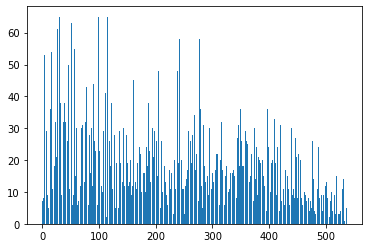

In [108]:
plt.bar([i for i in range(len(c_values))], c_values)
print(np.median(c_values))
print(np.mean(c_values))
print(np.std(c_values))

In [109]:
from scipy import stats
print(stats.mode(decode_ix))

ModeResult(mode=array([108]), count=array([65]))


(9940, 4)


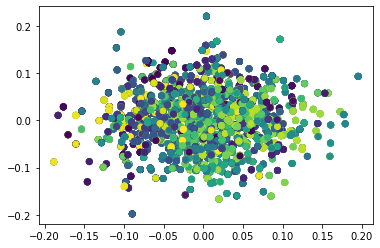

In [110]:
Zs_valid = np.array(Zs_valid)
print(Zs_valid.shape)

pca = PCA(n_components=2)
sampled_components = pca.fit_transform(Zs_valid)
# plt.scatter(components[:,0], components[:,1], c=extended[:,6])

plt.scatter(sampled_components[:,0], sampled_components[:,1], c=decode_ix)


# plt.scatter(Zs_valid[:,0], Zs_valid[:,1], c=decode_ix)

323
65
65


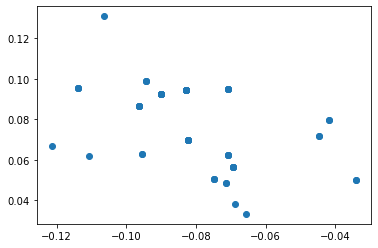

In [111]:
most_common = counter.most_common(1)[0][0]
print(most_common)

to_print = [ix for ix in range(len(decode_ix)) if decode_ix[ix] == most_common]
print(len(to_print))
Zs_valid_filtered = [Zs_valid[x] for x in range(len(Zs_valid)) if x in to_print]
print(len(Zs_valid_filtered))
Zs_valid_filtered = np.array(Zs_valid_filtered)
plt.scatter(Zs_valid_filtered[:,0], Zs_valid_filtered[:,1])

(60, 4)


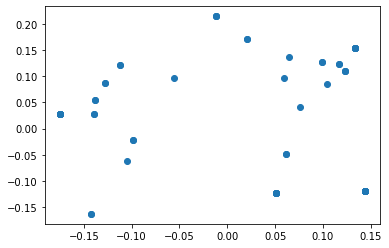

In [112]:
Zs_invalid = np.array(Zs_invalid)
print(Zs_invalid.shape)
plt.scatter(Zs_invalid[:,0], Zs_invalid[:,1])

In [113]:
plt.bar([i for i in range(400)], r[:400])


NameError: name 'r' is not defined

In [114]:
print(np.sum(r))
print(np.mean(r))
print(np.median(r))
print(len(valid2)/len(all_data2))
max_ix =np.argmax(r) 
print(max_ix)
print(np.sqrt(np.var(r)))
print(all_data[max_ix])
print(latents[max_ix])

NameError: name 'r' is not defined